In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Conv2D, Convolution2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU, Flatten, Dense, Reshape
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load cifar10 dataset
(_, _), (x_val, y_val) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# batch size
batch_size = 100

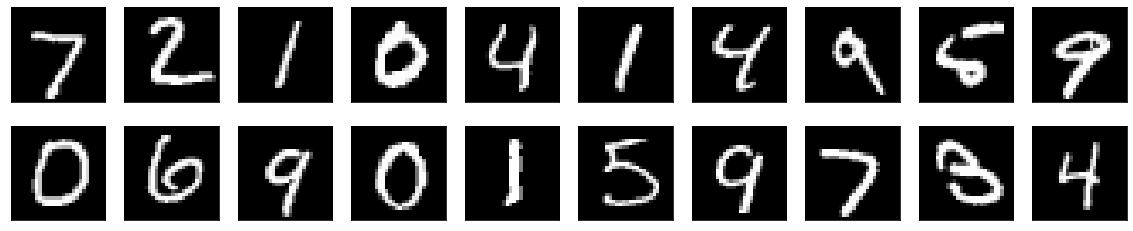

In [4]:
# show some training images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(x_val[idx], cmap = 'gray')

In [5]:
print("Number of Validation Samples: ", len(x_val))

Number of Validation Samples:  10000


In [6]:
# shape of images
print("Shape of Validation images: ", x_val.shape)

Shape of Validation images:  (10000, 28, 28)


In [7]:
# change data type
x_val = x_val.astype('float32')

In [8]:
# normalize data into range 1-0
x_val /= 255.0

In [9]:
print("Validation shape: ", x_val.shape)

Validation shape:  (10000, 28, 28)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pickle
fgsm_test = open('./drive/My Drive/PhD_Thesis/adversarial_noise/mnist_jsma_nosie.pickle', 'rb')
fgsm_noise_test = pickle.load(fgsm_test)

In [12]:
fgsm_noise_test.shape

(1000, 28, 28, 1)

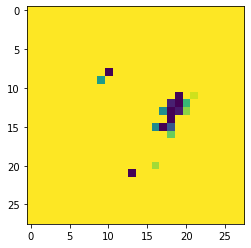

In [13]:
fgsm_noise_test.shape
plt.imshow(fgsm_noise_test[0].reshape(28, 28))

In [14]:
x_val = x_val[:1000].reshape(1000, 28, 28, 1)

In [15]:
x_val_noise = x_val + fgsm_noise_test
x_val_noise.shape

(1000, 28, 28, 1)

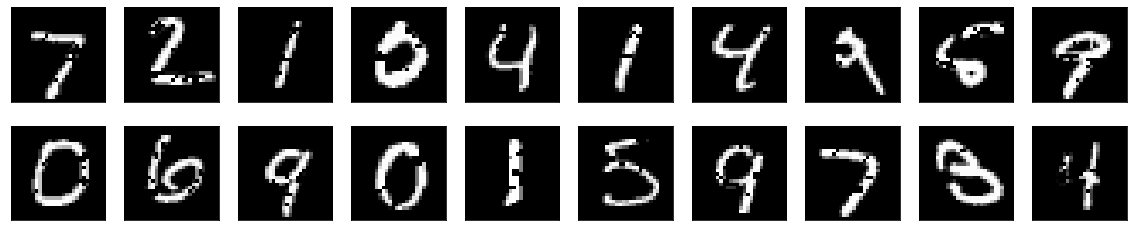

In [16]:
# show some training images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  plt.imshow(np.clip(x_val_noise[idx].reshape(28, 28), 0, 1), cmap = 'gray')

In [63]:
# define encoder
 
inputs = layers.Input(shape = [28, 28, 1])
x = inputs

x = Conv2D(filters = 64, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)
  
x = Conv2D(filters = 128, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2D(filters = 256, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2D(filters = 512, kernel_size = (3, 3), strides = 2, padding = 'same', activation = relu)(x)
x = Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)


x = Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = Dense(units = 2048, activation = relu)(x)

# Decoder
x = Reshape((2, 2, 512))(x)
x = Conv2DTranspose(filters = 512, kernel_size = (3, 3), strides = 2)(x)
x = Conv2D(filters = 512, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(filters = 256, kernel_size = (3, 3), strides = 1)(x)
x = Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(filters = 128, kernel_size = (3, 3), strides = 2, padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(filters = 64, kernel_size = (3, 3), strides = 2, padding = 'same')(x)
x = Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)
x = BatchNormalization()(x)

out = tf.keras.layers.Dropout(0.2)(x)
out = Conv2D(filters = 1, kernel_size = (3, 3), strides = 1, padding = 'same', activation = relu)(x)

DIR = Model(inputs = inputs, outputs = out)
DIR.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_229 (Conv2D)         (None, 14, 14, 64)        640       
                                                                 
 conv2d_230 (Conv2D)         (None, 14, 14, 64)        36928     
                                                                 
 batch_normalization_110 (Ba  (None, 14, 14, 64)       256       
 tchNormalization)                                               
                                                                 
 conv2d_231 (Conv2D)         (None, 7, 7, 128)         73856     
                                                                 
 conv2d_232 (Conv2D)         (None, 7, 7, 128)         147584    
                                                          

In [64]:
model_path = './drive/My Drive/PhD_Thesis/Generative_Models/dir_mnist_jsma.h5'
checkpoint = ModelCheckpoint(model_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 20)

callbacks_list = [checkpoint, early]

In [65]:
DIR.compile(loss = 'mse', optimizer = tf.keras.optimizers.RMSprop(learning_rate = 3e-4))

In [66]:
DIR.fit(x_val_noise, x_val,
                      validation_data = (x_val_noise, x_val),
                      epochs = 300, batch_size = 100, callbacks = callbacks_list)

Epoch 1/300
10/10 [==============================] - ETA: 0s - loss: 0.3265
Epoch 1: val_loss improved from inf to 0.10398, saving model to ./drive/My Drive/PhD_Thesis/Generative_Models/dir_mnist_jsma.h5
10/10 [==============================] - 30s 407ms/step - loss: 0.3265 - val_loss: 0.1040
Epoch 2/300
10/10 [==============================] - ETA: 0s - loss: 0.0783
Epoch 2: val_loss improved from 0.10398 to 0.10382, saving model to ./drive/My Drive/PhD_Thesis/Generative_Models/dir_mnist_jsma.h5
10/10 [==============================] - 2s 176ms/step - loss: 0.0783 - val_loss: 0.1038
Epoch 3/300
10/10 [==============================] - ETA: 0s - loss: 0.0729
Epoch 3: val_loss improved from 0.10382 to 0.10118, saving model to ./drive/My Drive/PhD_Thesis/Generative_Models/dir_mnist_jsma.h5
10/10 [==============================] - 2s 164ms/step - loss: 0.0729 - val_loss: 0.1012
Epoch 4/300
10/10 [==============================] - ETA: 0s - loss: 0.0645
Epoch 4: val_loss improved from 0.10

In [67]:
# sample and display images
dir = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/dir_mnist_jsma.h5')
outputs = dir.predict(x_val_noise)

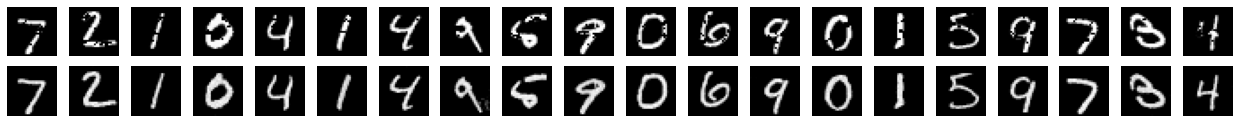

In [68]:
# Display
grid_col = 20
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(np.clip(x_val_noise[i,:,:,0], 0, 1), cmap = 'gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1,col].axis('off')        
        i += 1